<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/Cifar10-Classification-Custom-ResNet/cifar10_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"Training Images: {X_train.shape}")
print(f"Training Labels: {y_train.shape}")
print(f"Test Images: {X_test.shape}")
print(f"Test Labels: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training Images: (50000, 32, 32, 3)
Training Labels: (50000, 1)
Test Images: (10000, 32, 32, 3)
Test Labels: (10000, 1)


# Display Samples

In [3]:
import numpy as np

# Define CIFAR-10 class names
cifar10_class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

# Reshape y_train and y_test to 1D arrays for easier counting
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

print("Samples per class in Training Data:")
# Use np.bincount for efficient counting of non-negative integers
train_counts = np.bincount(y_train_flat)
for i, count in enumerate(train_counts):
    print(f"  {cifar10_class_names[i]}: {count}")

print("\nSamples per class in Test Data:")
test_counts = np.bincount(y_test_flat)
for i, count in enumerate(test_counts):
    print(f"  {cifar10_class_names[i]}: {count}")

Samples per class in Training Data:
  airplane: 5000
  automobile: 5000
  bird: 5000
  cat: 5000
  deer: 5000
  dog: 5000
  frog: 5000
  horse: 5000
  ship: 5000
  truck: 5000

Samples per class in Test Data:
  airplane: 1000
  automobile: 1000
  bird: 1000
  cat: 1000
  deer: 1000
  dog: 1000
  frog: 1000
  horse: 1000
  ship: 1000
  truck: 1000


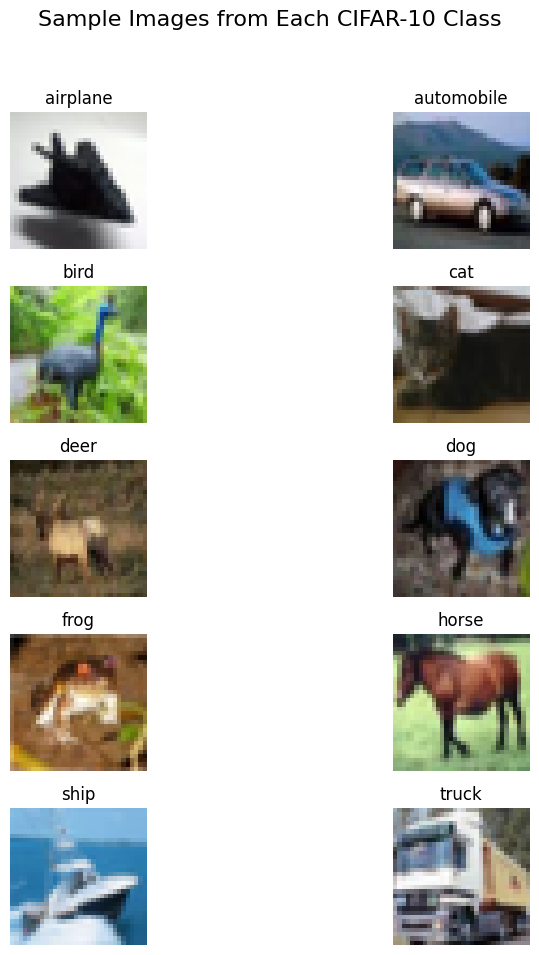

In [4]:
import matplotlib.pyplot as plt

# Create a figure to display images
plt.figure(figsize=(10, 10))

for i in range(len(cifar10_class_names)): # Iterate through each class
    # Find an index of an image belonging to the current class
    idx = np.where(y_train == i)[0][0]

    # Create a subplot for each image
    plt.subplot(5, 2, i + 1) # 5 rows, 2 columns
    plt.imshow(X_train[idx])
    plt.title(f"{cifar10_class_names[i]}")
    plt.axis('off')

plt.suptitle('Sample Images from Each CIFAR-10 Class', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Normalize Images

In [6]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.
    return x, tf.squeeze(y)


# Augmentation block
def augment(x, y):
    x = tf.image.resize_with_crop_or_pad(x, 40, 40) # اضافه کردن حاشیه (Padding)
    x = tf.image.random_crop(x, size=[32, 32, 3])   # حالا کراپ معنی می‌دهد
    x = tf.image.random_flip_left_right(x)
    return x, y

BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(50000)
    .map(augment, num_parallel_calls=AUTOTUNE) # Augmentation now applied before batching
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Custom `ResNet`

In [11]:
from tensorflow.keras import regularizers

# Hyperparameters
WEIGHT_DECAY = 1e-4

def basic_block(x, filters, strides=1):
    shortcut = x

    # First Conv
    out = layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    out = layers.BatchNormalization()(out)
    out = layers.Activation('relu')(out)

    # Second Conv
    out = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False,
                        kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(out)
    out = layers.BatchNormalization()(out)

    # Shortcut Projection
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False,
                                 kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
        shortcut = layers.BatchNormalization()(shortcut)

    out = layers.Add()([out, shortcut])
    out = layers.Activation('relu')(out)
    return out

def make_stage(x, filters, num_blocks, strides=1):
    x = basic_block(x, filters, strides=strides)
    for _ in range(1, num_blocks):
        x = basic_block(x, filters)
    return x

def ResNet20(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv
    x = layers.Conv2D(16, 3, strides=1, padding='same', use_bias=False,
                      kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # ResNet structure: [16, 32, 64] filters with [3, 3, 3] blocks creates ResNet20
    # Stage 1
    x = make_stage(x, 16, 3, strides=1)
    # Stage 2
    x = make_stage(x, 32, 3, strides=2)
    # Stage 3
    x = make_stage(x, 64, 3, strides=2)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax",
                           kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)

    return Model(inputs, outputs)

model = ResNet20((32, 32, 3), 10)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        432 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,304 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,304 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,304 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      2,304 │ activation_3[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 274,042 (1.05 MB)

 Trainable params: 272,474 (1.04 MB)

 Non-trainable params: 1,568 (6.12 KB)

## Training the Custom ResNet

In [12]:
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

model.compile(
    optimizer=OPTIMIZER,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully with Adam optimizer, SparseCategoricalCrossentropy loss, and accuracy metrics.")

Model compiled successfully with Adam optimizer, SparseCategoricalCrossentropy loss, and accuracy metrics.


In [13]:
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 120:
        lr = 0.001
    elif epoch > 80:
        lr = 0.01
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [14]:
history = model.fit(
    train_ds,
    batch_size=64,
    epochs=150,
    validation_data=test_ds,
    callbacks=[lr_callback]
)

Epoch 1/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.2913 - loss: 1.9990 - val_accuracy: 0.2296 - val_loss: 2.7701 - learning_rate: 0.1000
Epoch 2/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5443 - loss: 1.3378 - val_accuracy: 0.4595 - val_loss: 2.2063 - learning_rate: 0.1000
Epoch 3/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6486 - loss: 1.0844 - val_accuracy: 0.6578 - val_loss: 1.1362 - learning_rate: 0.1000
Epoch 4/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7153 - loss: 0.9240 - val_accuracy: 0.7071 - val_loss: 0.9824 - learning_rate: 0.1000
Epoch 5/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7543 - loss: 0.8238 - val_accuracy: 0.7188 - val_loss: 0.9807 - learning_rate: 0.1000
Epoch 6/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7824 - loss: 0.7666 - val_accuracy: 0.7360 - val_loss: 0.9606 - learning_rate: 0.1000
Epoch 7/150
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7

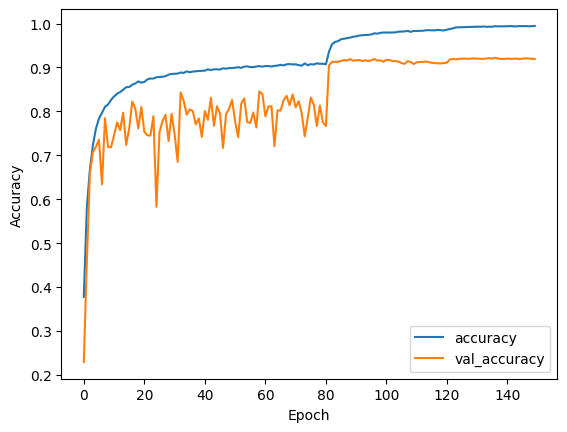

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()